In [582]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import NeuralNetwork as NN
import Layer
import importlib
importlib.reload(NN)
importlib.reload(Layer)

<module 'Layer' from '/Users/jorchard/Dropbox/research/peBogacz/python/Layer.py'>

In [583]:
net = NN.NeuralNetwork()
l = Layer.InputPELayer(n=2)
net.AddLayer(l)
net.AddLayer(Layer.PELayer(n=2))
net.AddLayer(Layer.PELayer(n=2))

In [584]:
net.SetIdentityWeights()
net.SetInput([1., 0])

In [585]:
net.ShowState()

Layer 0 (input):
  v = [1. 0.]
  e = [0. 0.]
Layer 1:
  v = [0. 0.]
  e = [0. 0.]
Layer 2:
  v = [0. 0.]
  e = [0. 0.]


In [586]:
net.ShowState()

Layer 0 (input):
  v = [1. 0.]
  e = [0. 0.]
Layer 1:
  v = [0. 0.]
  e = [0. 0.]
Layer 2:
  v = [0. 0.]
  e = [0. 0.]


In [587]:
net.ShowWeights()

  W01 = 
[[1. 0.]
 [0. 1.]]
  M10 = 
[[1. 0.]
 [0. 1.]]
  W12 = 
[[1. 0.]
 [0. 1.]]
  M21 = 
[[1. 0.]
 [0. 1.]]


In [588]:
T = 3
dt = 0.001
tt = np.arange(0, T, dt)

In [589]:
net.Run(T, dt=dt)
net.ShowState()

Layer 0 (input):
  v = [1. 0.]
  e = [-0.01774575  0.        ]
Layer 1:
  v = [1.1474648 0.       ]
  e = [-0.0079303  0.       ]
Layer 2:
  v = [1.1938196 0.       ]
  e = [0. 0.]


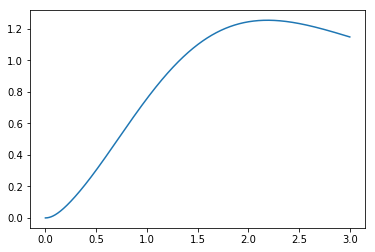

In [590]:
plt.plot(np.array(net.t_history), np.array(net.layers[1].v_history)[:,0]);